In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import joblib

data = fetch_california_housing(as_frame=True)
df = data.frame

df.head()




,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [ ]:
features = [
    'MedInc',
    'HouseAge',
    'AveRooms',
    'AveBedrms',
    'AveOccup'
]

target = 'MedHouseVal'

X = df[features].values
y = df[target].values.reshape(-1, 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train.shape, X_test.shape

((16512, 5), (4128, 5))

In [ ]:
x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train = x_scaler.fit_transform(X_train)
X_test = x_scaler.transform(X_test)

y_train = y_scaler.fit_transform(y_train)
y_test = y_scaler.transform(y_test)


In [ ]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32)



In [ ]:
class HousingRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
model = HousingRegressor(input_dim=X_train_t.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 1000
losses = []

for epoch in range(epochs):
    model.train()
    preds = model(X_train_t)
    loss = criterion(preds, y_train_t)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if epoch % 50 == 0:
        print(f"Epoch {epoch:03d} | Loss = {loss.item():.6f}")


Epoch 000 | Loss = 1.015943
Epoch 050 | Loss = 0.481312
Epoch 100 | Loss = 0.404325
Epoch 150 | Loss = 0.376916
Epoch 200 | Loss = 0.357475
Epoch 250 | Loss = 0.341901
Epoch 300 | Loss = 0.330084
Epoch 350 | Loss = 0.322122
Epoch 400 | Loss = 0.316057
Epoch 450 | Loss = 0.310762
Epoch 500 | Loss = 0.306640
Epoch 550 | Loss = 0.302736
Epoch 600 | Loss = 0.299265
Epoch 650 | Loss = 0.295920
Epoch 700 | Loss = 0.293173
Epoch 750 | Loss = 0.291299
Epoch 800 | Loss = 0.289990
Epoch 850 | Loss = 0.288810
Epoch 900 | Loss = 0.287890
Epoch 950 | Loss = 0.287086


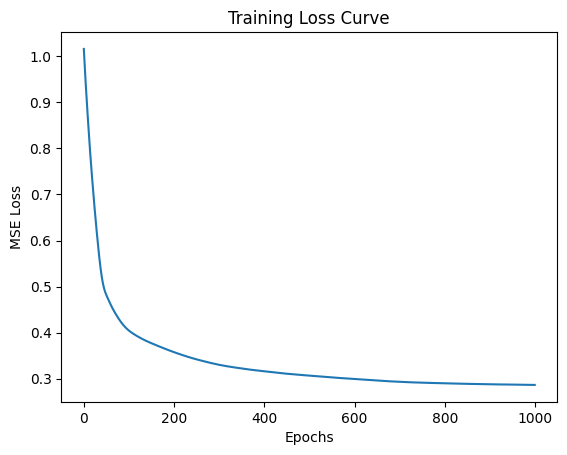

In [ ]:
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Training Loss Curve")
plt.show()


In [ ]:
model.eval()
with torch.no_grad():
    test_pred_scaled = model(X_test_t)

test_pred = y_scaler.inverse_transform(test_pred_scaled.numpy())
y_test_orig = y_scaler.inverse_transform(y_test)

mse = mean_squared_error(y_test_orig, test_pred)
r2  = r2_score(y_test_orig, test_pred)

print("Test MSE:", mse)
print("Test R² :", r2)


Test MSE: 0.42227216174563276
Test R² : 0.6777554421883668


In [ ]:
torch.save(model.state_dict(), "housing_model.pt")
joblib.dump(x_scaler, "x_scaler.save")
joblib.dump(y_scaler, "y_scaler.save")


['y_scaler.save']

In [ ]:
for param in model.parameters():
    param.requires_grad = False

model.eval()


HousingRegressor(
  (net): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [ ]:
target_price = 3.0
target_scaled = y_scaler.transform([[target_price]])
target_t = torch.tensor(target_scaled, dtype=torch.float32)


In [ ]:
x_init = [[
    5.0,   # MedInc
    25,    # HouseAge
    5.0,   # AveRooms
    1.0,   # AveBedrms
    3.0    # AveOccup
]]

x_init_scaled = x_scaler.transform(x_init)
x_opt = torch.tensor(x_init_scaled, dtype=torch.float32, requires_grad=True)


In [ ]:
optimizer_x = torch.optim.Adam([x_opt], lr=0.05)


In [ ]:
constraints = {
    'MedInc': (1.0, 15.0),
    'HouseAge': (1, 50),
    'AveRooms': (1.0, 10.0),
    'AveBedrms': (0.5, 5.0),
    'AveOccup': (1.0, 6.0)
}


In [ ]:
nio_losses = []
predicted_prices = []

for step in range(1000):
    pred = model(x_opt)
    loss = (pred - target_t).pow(2)

    optimizer_x.zero_grad()
    loss.backward()
    optimizer_x.step()

    # Clamp constraints
    x_unscaled = x_scaler.inverse_transform(x_opt.detach().numpy())

    for i, (key, (low, high)) in enumerate(constraints.items()):
        x_unscaled[0, i] = np.clip(x_unscaled[0, i], low, high)

    x_opt.data = torch.tensor(
        x_scaler.transform(x_unscaled),
        dtype=torch.float32
    )

    nio_losses.append(loss.item())
    price = y_scaler.inverse_transform(pred.detach().numpy())[0][0]
    predicted_prices.append(price)

    if step % 100 == 0:
        print(f"Step {step:03d} | Predicted Value = {price:.3f}")


Step 000 | Predicted Value = 2.522
Step 100 | Predicted Value = 3.000
Step 200 | Predicted Value = 3.000
Step 300 | Predicted Value = 3.000
Step 400 | Predicted Value = 3.000
Step 500 | Predicted Value = 3.000
Step 600 | Predicted Value = 3.000
Step 700 | Predicted Value = 3.000
Step 800 | Predicted Value = 3.000
Step 900 | Predicted Value = 3.000


In [ ]:
final_input = x_scaler.inverse_transform(x_opt.detach().numpy())

print("\nOptimized Input Features:")
for i, feat in enumerate(features):
    print(f"{feat}: {final_input[0][i]:.3f}")

print("\nFinal Predicted House Value ($100k units):", predicted_prices[-1])
print("Target Value ($100k units):", target_price)



Optimized Input Features:
MedInc: 5.060
HouseAge: 22.789
AveRooms: 4.937
AveBedrms: 0.996
AveOccup: 2.334

Final Predicted House Value ($100k units): 3.0000002
Target Value ($100k units): 3.0


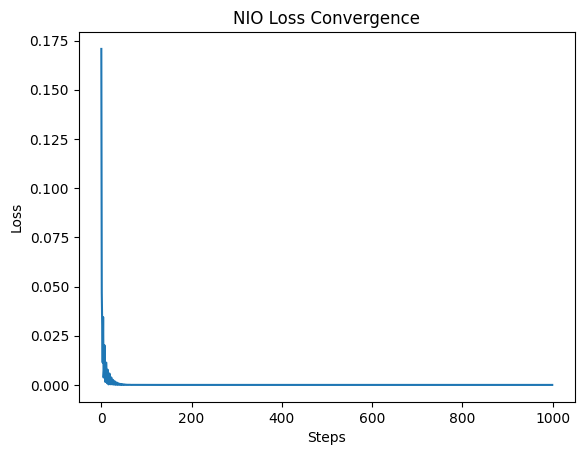

In [ ]:
plt.plot(nio_losses)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("NIO Loss Convergence")
plt.show()


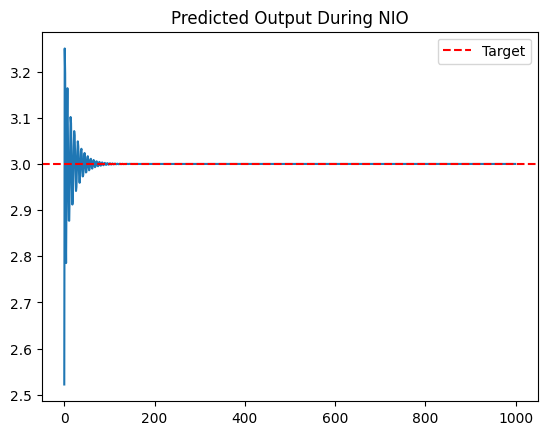

In [ ]:
plt.plot(predicted_prices)
plt.axhline(target_price, color='red', linestyle='--', label="Target")
plt.legend()
plt.title("Predicted Output During NIO")
plt.show()
